Imports

In [89]:
import numpy as np
import pandas as pd
from rdkit import Chem

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import sklearn.metrics as metrics

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

Get data from original tables and get fingerprints

In [77]:
SMILES_data = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")
SMILES_data_final = pd.read_csv("X_test.csv")

# create a list of mols
mols = [Chem.MolFromSmiles(smiles) for smiles in SMILES_data['SMILES']]

# create a list of fingerprints from mols
fps = [Chem.RDKFingerprint(mol) for mol in mols]

X = pd.DataFrame(np.array(fps))
X.insert(loc=0, column='ID', value=SMILES_data['ID'].values)

# create a list of mols
mols1 = [Chem.MolFromSmiles(smiles) for smiles in SMILES_data_final['SMILES']]

# create a list of fingerprints from mols
fps1 = [Chem.RDKFingerprint(mol) for mol in mols1]

X_final_test = pd.DataFrame(np.array(fps1))

X_final_test.insert(loc=0, column='ID', value=SMILES_data_final['ID'].values)

X.head()


,ID,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,1,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,1,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,3,1,1,0,0,0,1,1,0,1,...,0,1,1,0,1,0,1,1,0,1
4,4,0,1,1,0,0,1,1,1,0,...,1,0,0,0,0,0,0,1,0,0


Perform cross-validation

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

Baseline model w/ Decision Trees

In [81]:
# Train the three models
model_1 = DecisionTreeClassifier(random_state=1)
model_1.fit(X_train.iloc[:, 1:], y_train['Y1'].values)

model_2 = DecisionTreeClassifier(random_state=1)
model_2.fit(X_train.iloc[:, 1:], y_train['Y2'].values)

model_3 = DecisionTreeClassifier(random_state=1)
model_3.fit(X_train.iloc[:, 1:], y_train['Y3'].values)

DecisionTreeClassifier(random_state=1)

In [87]:
# Predict the three ADMET properties
y_pred_1 = model_1.predict(X_test.iloc[:, 1:])
y_pred_2 = model_2.predict(X_test.iloc[:, 1:])
y_pred_3 = model_3.predict(X_test.iloc[:, 1:])

In [88]:
y_pred = pd.DataFrame({'ID': X_test['ID'], 'Y1': y_pred_1, 'Y2': y_pred_2, 'Y3': y_pred_3})

y_pred

,ID,Y1,Y2,Y3
367,367,0,1,0
50,50,0,1,0
576,576,0,0,0
1101,1101,1,0,1
55,55,1,0,1
...,...,...,...,...
1365,1365,1,1,1
1440,1440,1,0,0
1872,1872,1,0,1
1810,1810,0,0,0


Attempt to use sk multilearn

In [ ]:
clf = BinaryRelevance(
    classifier=SVC())

clf.fit(X_train, y_train.loc[:,['Y1', 'Y2', 'Y3']])

prediction = clf.predict(X_test)

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
classifier = MultiOutputClassifier(knn, n_jobs=-1)
classifier.fit(X_train,y_train.loc[:,['Y1', 'Y2', 'Y3']]).predict(X_test)

In [ ]:
metrics.hamming_loss(y_test, prediction)

In [ ]:
metrics.accuracy_score(y_test, prediction)

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
classifier = MultiOutputClassifier(knn, n_jobs=-1)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

Using PyTorch (Deep Learning)

In [93]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [95]:
X_data = X.to_numpy()
y_data = y.to_numpy()
X_final_test_data = X_final_test.to_numpy()

In [103]:
X_data = torch.from_numpy(X_data).type(torch.float)
y_data = torch.from_numpy(y_data).type(torch.float)

In [104]:
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(X_data, y_data, test_size=0.30, random_state=101)

X_train_pt = X_train_pt[:, 1:]
X_test_pt = X_test_pt[:, 1:]
y_train_pt = y_train_pt[:, 1:]
y_test_pt = y_test_pt[:, 1:]

In [194]:
model_pt = nn.Sequential(
    nn.Linear(in_features=X_train_pt.shape[1], out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=y_train_pt.shape[1])
    )

In [150]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_pt.parameters(),
                            lr = 0.1)

In [147]:
!pip install torchmetrics
!pip install torcheval

In [191]:
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [188]:
torch.set_warn_always(False)
import warnings
warnings.filterwarnings("ignore")

In [195]:
epochs = 400
train_loss = []
test_loss = []
epoch_count = []

train_f1_v = []
test_f1_v = []


for epoch in range(epochs):
    epoch_count.append(epoch)

    ### Train model

    model_pt.train()

    #y_pred_train = torch.round(torch.sigmoid(model_pt(X_train_pt)))
    y_pred_train = model_pt(X_train_pt)

    loss = loss_fn(y_pred_train, y_train_pt)

    prec_train_1 = precision_score(y_true=np.array(torch.tensor(y_train_pt[:,0]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,0]).numpy(), dtype='int'), average='micro')
    rec_train_1 = recall_score(y_true=np.array(torch.tensor(y_train_pt[:,0]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,0]).numpy(), dtype='int'), average='micro')
    f1_train_1 = 2 * (prec_train_1*rec_train_1)/(prec_train_1+rec_train_1)

    prec_train_2 = precision_score(y_true=np.array(torch.tensor(y_train_pt[:,1]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,1]).numpy(), dtype='int'), average='micro')
    rec_train_2 = recall_score(y_true=np.array(torch.tensor(y_train_pt[:,1]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,1]).numpy(), dtype='int'), average='micro')
    f1_train_2 = 2 * (prec_train_2*rec_train_2)/(prec_train_2+rec_train_2)

    prec_train_3 = precision_score(y_true=np.array(torch.tensor(y_train_pt[:,2]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,2]).numpy(), dtype='int'), average='micro')
    rec_train_3 = recall_score(y_true=np.array(torch.tensor(y_train_pt[:,2]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,2]).numpy(), dtype='int'), average='micro')
    f1_train_3 = 2 * (prec_train_3*rec_train_3)/(prec_train_3+rec_train_3)

    train_f1 = f1_train_1+f1_train_2+f1_train_3

    #train_f1 = f1_score(y_true=np.array(torch.tensor(y_train_pt[:,0]).numpy()), y_pred=np.array(torch.tensor(y_pred_train[:,0]).numpy(), dtype='int'), average='micro')
    train_f1_v.append(train_f1)

    train_loss.append(loss)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Evalualte model

    model_pt.eval()

    with torch.inference_mode():
        y_pred_test = model_pt(X_test_pt)

    loss_test = loss_fn(y_pred_test, y_test_pt)
    test_loss.append(loss_test)

    prec_test_1 = precision_score(y_true=np.array(torch.tensor(y_test_pt[:,0]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,0]).numpy(), dtype='int'), average='micro')
    rec_test_1 = recall_score(y_true=np.array(torch.tensor(y_test_pt[:,0]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,0]).numpy(), dtype='int'), average='micro')
    f1_test_1 = 2 * (prec_train_1*rec_train_1)/(prec_train_1+rec_train_1)

    prec_test_2 = precision_score(y_true=np.array(torch.tensor(y_test_pt[:,1]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,1]).numpy(), dtype='int'), average='micro')
    rec_test_2 = recall_score(y_true=np.array(torch.tensor(y_test_pt[:,1]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,1]).numpy(), dtype='int'), average='micro')
    f1_test_2 = 2 * (prec_train_2*rec_train_2)/(prec_train_2+rec_train_2)

    prec_test_3 = precision_score(y_true=np.array(torch.tensor(y_test_pt[:,2]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,2]).numpy(), dtype='int'), average='micro')
    rec_test_3 = recall_score(y_true=np.array(torch.tensor(y_test_pt[:,2]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,2]).numpy(), dtype='int'), average='micro')
    f1_test_3 = 2 * (prec_train_3*rec_train_3)/(prec_train_3+rec_train_3)

    test_f1 = f1_test_1+f1_test_2+f1_test_3

    #test_f1 = f1_score(y_true=np.array(torch.tensor(y_test_pt[:,0]).numpy()), y_pred=np.array(torch.tensor(y_pred_test[:,0]).numpy(), dtype='int'), average='micro')
    test_f1_v.append(test_f1)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} ||| train loss {loss} ||| test loss {loss_test} ||| train f1 {train_f1} ||| test f1 {test_f1}")

Epoch 0 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 10 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 20 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 30 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 40 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 50 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 60 ||| train loss 0.6935365200042725 ||| test loss 0.6939478516578674 ||| train f1 1.5202354672553349 ||| test f1 1.5202354672553349
Epoch 70 ||| train loss 0.69

In [135]:
import matplotlib.pyplot as plt

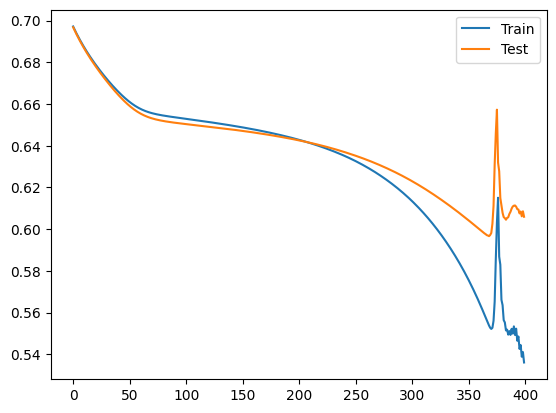

In [144]:
plt.plot(epoch_count, np.array(torch.tensor(train_loss).numpy()), label='Train')
plt.plot(epoch_count, np.array(torch.tensor(test_loss).numpy()), label='Test')
plt.legend()
plt.show()